In [8]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from typing import List, Optional, Any
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gluonts
import optuna
from IPython.display import display, HTML
import time
import warnings

warnings.filterwarnings("ignore")

class DeepARForecasting:
    def __init__(self, start_date: str, freq: str = 'ME', prediction_length: int = 5, epochs: int = 50, num_batches_per_epoch: int = 100):
        self.start_date = pd.Timestamp(start_date)
        self.freq = freq
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.num_batches_per_epoch = num_batches_per_epoch
        self.time_series = []
        self.titles = []
        self.train_ds = None
        self.predictor = None
        
        # Set seeds for reproducibility
        np.random.seed(42)
        mx.random.seed(42)

    def add_time_series(self, series: np.ndarray, title: str):
        self.time_series.append(series)
        self.titles.append(title)

    def prepare_dataset(self):
        self.train_ds = ListDataset(
            [{"start": self.start_date, "target": series[:-self.prediction_length]} for series in self.time_series],
            freq=self.freq
        )


    class DeepARTuningObjective:
        def __init__(self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"):
            self.dataset = dataset
            self.prediction_length = prediction_length
            self.freq = freq
            self.metric_type = metric_type

            self.train, test_template = gluonts.dataset.split.split(dataset, offset=-prediction_length)
            validation = test_template.generate_instances(prediction_length=prediction_length)
            self.validation_input = [entry[0] for entry in validation]
            self.validation_label = [self.dataentry_to_dataframe(entry[1]) for entry in validation]

        @staticmethod
        def dataentry_to_dataframe(entry):
            return pd.DataFrame(
                entry["target"],
                columns=[entry.get("item_id")],
                index=pd.period_range(
                    start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
                ),
            )

        def __call__(self, trial):
            num_layers = trial.suggest_int("num_layers", 1, 2)
            neurons_per_layer = trial.suggest_categorical("neurons_per_layer", [8, 16, 32])

            estimator = DeepAREstimator(
                num_layers=num_layers,
                num_cells=neurons_per_layer,  # Now using a single integer value
                prediction_length=self.prediction_length,
                freq=self.freq,
                trainer=Trainer(epochs=10, num_batches_per_epoch=100)
            )

            predictor = estimator.train(self.train)
            forecast_it = predictor.predict(self.validation_input)
            forecasts = list(forecast_it)

            evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
            agg_metrics, _ = evaluator(self.validation_label, forecasts, num_series=len(self.dataset))
            return agg_metrics[self.metric_type]

    def train_model(self, **params):
        estimator = DeepAREstimator(
            freq=self.freq,
            prediction_length=self.prediction_length,
            trainer=Trainer(epochs=self.epochs, num_batches_per_epoch=self.num_batches_per_epoch),
            num_layers=params.get('num_layers', 2),
            num_cells=params.get('neurons_per_layer', 40)  # Now using a single integer value
        )
        return estimator.train(self.train_ds)

    def tune_hyperparameters(self, n_trials=5):
        start_time = time.time()
        study = optuna.create_study(direction="minimize")
        study.optimize(
            self.DeepARTuningObjective(
                self.train_ds, self.prediction_length, self.freq
            ),
            n_trials=n_trials
        )

        print("Number of finished trials: {}".format(len(study.trials)))
        print("\nBest trial:")
        trial = study.best_trial
        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))

        return trial.params, trial.value


    def make_predictions(self, predictor, series_index: int = 0):
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=ListDataset(
                [{"start": self.start_date, "target": self.time_series[series_index]}],
                freq=self.freq
            ),
            predictor=predictor,
            num_samples=100
        )
        
        forecasts = list(forecast_it)
        tss = list(ts_it)
        return forecasts[0], pd.Series(
            self.time_series[series_index][-self.prediction_length:],
            index=pd.date_range(start=self.start_date + pd.Timedelta(days=(len(self.time_series[series_index])-self.prediction_length)*30), 
                                periods=self.prediction_length, 
                                freq=self.freq)
        )

    def plot_prediction_distribution(self, forecast, test_data: pd.Series, title: str, bw_method: Optional[Any] = None, **fig_kw):
        samples = forecast.samples
        prediction_length = samples.shape[1]
        
        figsize = fig_kw.pop('figsize', (12, 4*prediction_length))
        
        fig, axs = plt.subplots(prediction_length, 1, figsize=figsize, sharex=True, **fig_kw)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
        
        palette = sns.color_palette("viridis", prediction_length)
        
        legend_handles = []
        legend_labels = []
        
        for i in range(prediction_length):
            step_samples = samples[:, i]
            
            sns.kdeplot(data=step_samples, ax=axs[i], fill=True, color=palette[i])
            
            prediction_mean = np.mean(step_samples)
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='--', linewidth=2)
            
            quantiles = [0.1, 0.5, 0.9]
            quantile_values = np.quantile(step_samples, quantiles)
            quantile_lines = [axs[i].axvline(x=q, color='green', linestyle=':', linewidth=1) for q in quantile_values]
            
            real_value = test_data.iloc[i]
            actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
            
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            axs[i].set_ylabel(f'Step {i+1}')
            axs[i].set_xlabel('Prediction')
            
            if i == 0:
                legend_handles.extend([mean_line, actual_line, quantile_lines[1]])
                legend_labels.extend(['Prediction Mean', 'Actual Value', 'Median (50% quantile)'])
        
        fig.subplots_adjust(hspace=0.4)
        fig.suptitle(f"DeepAR Forecasting Distribution per Step - {title}")
        
        fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
        
        plt.show()

    def print_prediction_summary(self, forecast, test_data, title: str):
        mean_forecast = forecast.mean
        median_forecast = forecast.quantile(0.5)
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        print(f"Resumen de predicciones para {title}:")
        for i in range(len(mean_forecast)):
            print(f"\nPaso {i+1}:")
            print(f"  Valor real: {test_data.iloc[i]:.2f}")
            print(f"  Predicción media: {mean_forecast[i]:.2f}")
            print(f"  Predicción mediana: {median_forecast[i]:.2f}")
            print(f"  Intervalo de predicción (80%): [{lower_quantile[i]:.2f}, {upper_quantile[i]:.2f}]")

    def plot_actual_vs_predicted(self, forecast, test_data, train_data, title: str):
        mean_forecast = forecast.mean
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        # Create separate DataFrames for train and test data
        train_df = pd.DataFrame({'date': train_data.index, 'value': train_data.values})
        
        # Create test_df using the forecast dates
        forecast_dates = pd.date_range(start=train_df['date'].max() + pd.Timedelta(days=30), periods=len(mean_forecast), freq=self.freq)
        test_df = pd.DataFrame({'date': forecast_dates, 'value': test_data.values})
        
        # Create DataFrame for forecast
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'mean': mean_forecast,
            'lower': lower_quantile,
            'upper': upper_quantile
        })
        
        fig = make_subplots(specs=[[{"secondary_y": False}]])
        
        # Plot training data
        fig.add_trace(
            go.Scatter(x=train_df['date'], y=train_df['value'], name="Training Data", line=dict(color='blue'))
        )
        
        # Plot test data
        fig.add_trace(
            go.Scatter(x=test_df['date'], y=test_df['value'], name="Actual", mode='lines+markers', marker=dict(color='red', size=8))
        )
        
        # Plot mean forecast
        fig.add_trace(
            go.Scatter(x=forecast_df['date'], y=forecast_df['mean'], name="Predicted (mean)", mode='lines+markers', line=dict(color='green'))
        )
        
        # Plot prediction interval
        fig.add_trace(
            go.Scatter(
                x=forecast_df['date'].tolist() + forecast_df['date'][::-1].tolist(),
                y=forecast_df['upper'].tolist() + forecast_df['lower'][::-1].tolist(),
                fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=True,
                name="80% Prediction Interval"
            )
        )
        
        fig.update_layout(
            title=f"Actual vs Predicted Values (with Training Data) - {title}",
            xaxis_title="Date",
            yaxis_title="Value",
            legend_title="Legend",
            hovermode="x unified"
        )
        
        fig.show()

    def plot_input_series(self):
        """
        Plot all input time series.
        """
        n_series = len(self.time_series)
        fig, axs = plt.subplots(n_series, 1, figsize=(12, 4*n_series), sharex=True)
        
        if n_series == 1:
            axs = [axs]
        
        for i, (series, title) in enumerate(zip(self.time_series, self.titles)):
            dates = pd.date_range(start=self.start_date, periods=len(series), freq=self.freq)
            axs[i].plot(dates, series)
            axs[i].set_title(f"Input Time Series: {title}")
            axs[i].set_xlabel("Date")
            axs[i].set_ylabel("Value")
            
        plt.tight_layout()
        plt.show()

    def run_forecasting_process(self, series_index: int = 0, n_trials: int = 5):
        self.plot_input_series()
        self.prepare_dataset()
        
        print("Starting hyperparameter tuning...")
        best_params, best_value = self.tune_hyperparameters(n_trials)
        
        print("\nTraining model with best parameters...")
        self.predictor = self.train_model(**best_params)
        
        forecast, test_data = self.make_predictions(self.predictor, series_index)
        
        train_data = pd.Series(
            self.time_series[series_index][:-self.prediction_length],
            index=pd.date_range(start=self.start_date, periods=len(self.time_series[series_index])-self.prediction_length, freq=self.freq)
        )
        
        title = self.titles[series_index]
        self.plot_prediction_distribution(forecast, test_data, title)
        self.print_prediction_summary(forecast, test_data, title)
        self.plot_actual_vs_predicted(forecast, test_data, train_data, title)

        # Display results of hyperparameter optimization
        results = f"""
        <h3>Hyperparameter Optimization Results</h3>
        <p>The best hyperparameters found during the optimization process are:</p>
        <ul>
            <li>Number of layers: {best_params['num_layers']}</li>
            <li>Neurons per layer: {best_params['neurons_per_layer']}</li>
        </ul>
        <p>The optimization value (mean weighted quantile loss) achieved with these parameters is: {best_value:.4f}</p>
        <p>This optimization aims to minimize the mean weighted quantile loss, which measures the accuracy of the probabilistic forecasts across different quantiles.</p>
        """
        display(HTML(results))

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


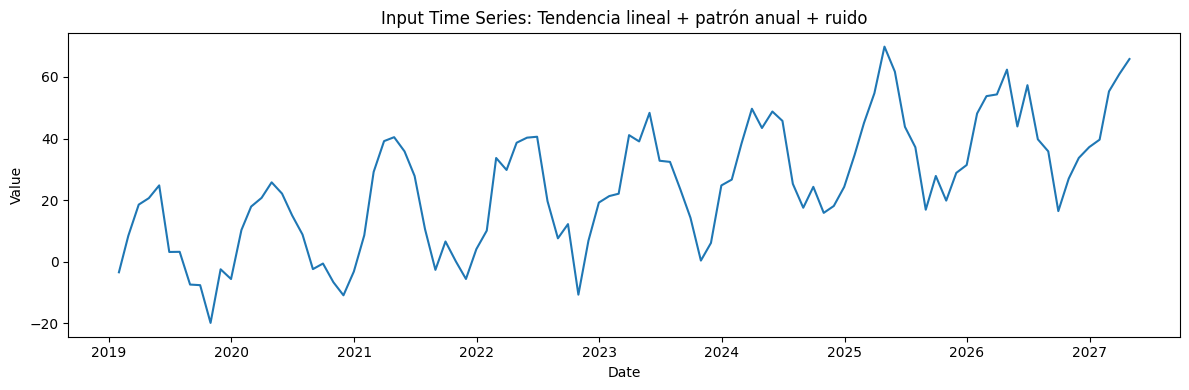

[I 2024-09-23 21:02:01,970] A new study created in memory with name: no-name-96721113-84ab-4258-b0f7-66b059ce2230


Starting hyperparameter tuning...


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
[I 2024-09-23 21:02:39,949] Trial 0 finished with value: 0.1829901544431948 and parameters: {'num_layers': 1, 'neurons_per_layer': 16}. Best is trial 0 with value: 0.1829901544431948.
Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]
[I 2024-09-23 21:03:24,975] Trial 1 finished with value: 0.15597448051147855 and parameters: {'num_layers': 2, 'neurons_per_layer': 16}. Best is trial 1 with value: 0.15597448051147855.
Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
[I 2024-09-23 21:04:02,087] Trial 2 finished with value: 0.14522331387922377 and parameters: {'num_layers': 1, 'neurons_per_layer': 16}. Best is trial 2 with value: 0.14522331387922377.
Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]
[I 2024-09-23 21:04:41,853] Trial 3 finished with value: 0.1735250402362475 and parameters: {'num_layers': 2, 'neurons_per_layer': 8}. Best is trial 2 with value: 0.145223313879223

Number of finished trials: 5

Best trial:
  Value: 0.14522331387922377
  Params: 
    num_layers: 1
    neurons_per_layer: 16
Time taken: 194.64 seconds

Training model with best parameters...


100%|██████████| 100/100 [00:03<00:00, 28.62it/s, epoch=20/20, avg_epoch_loss=2.14]


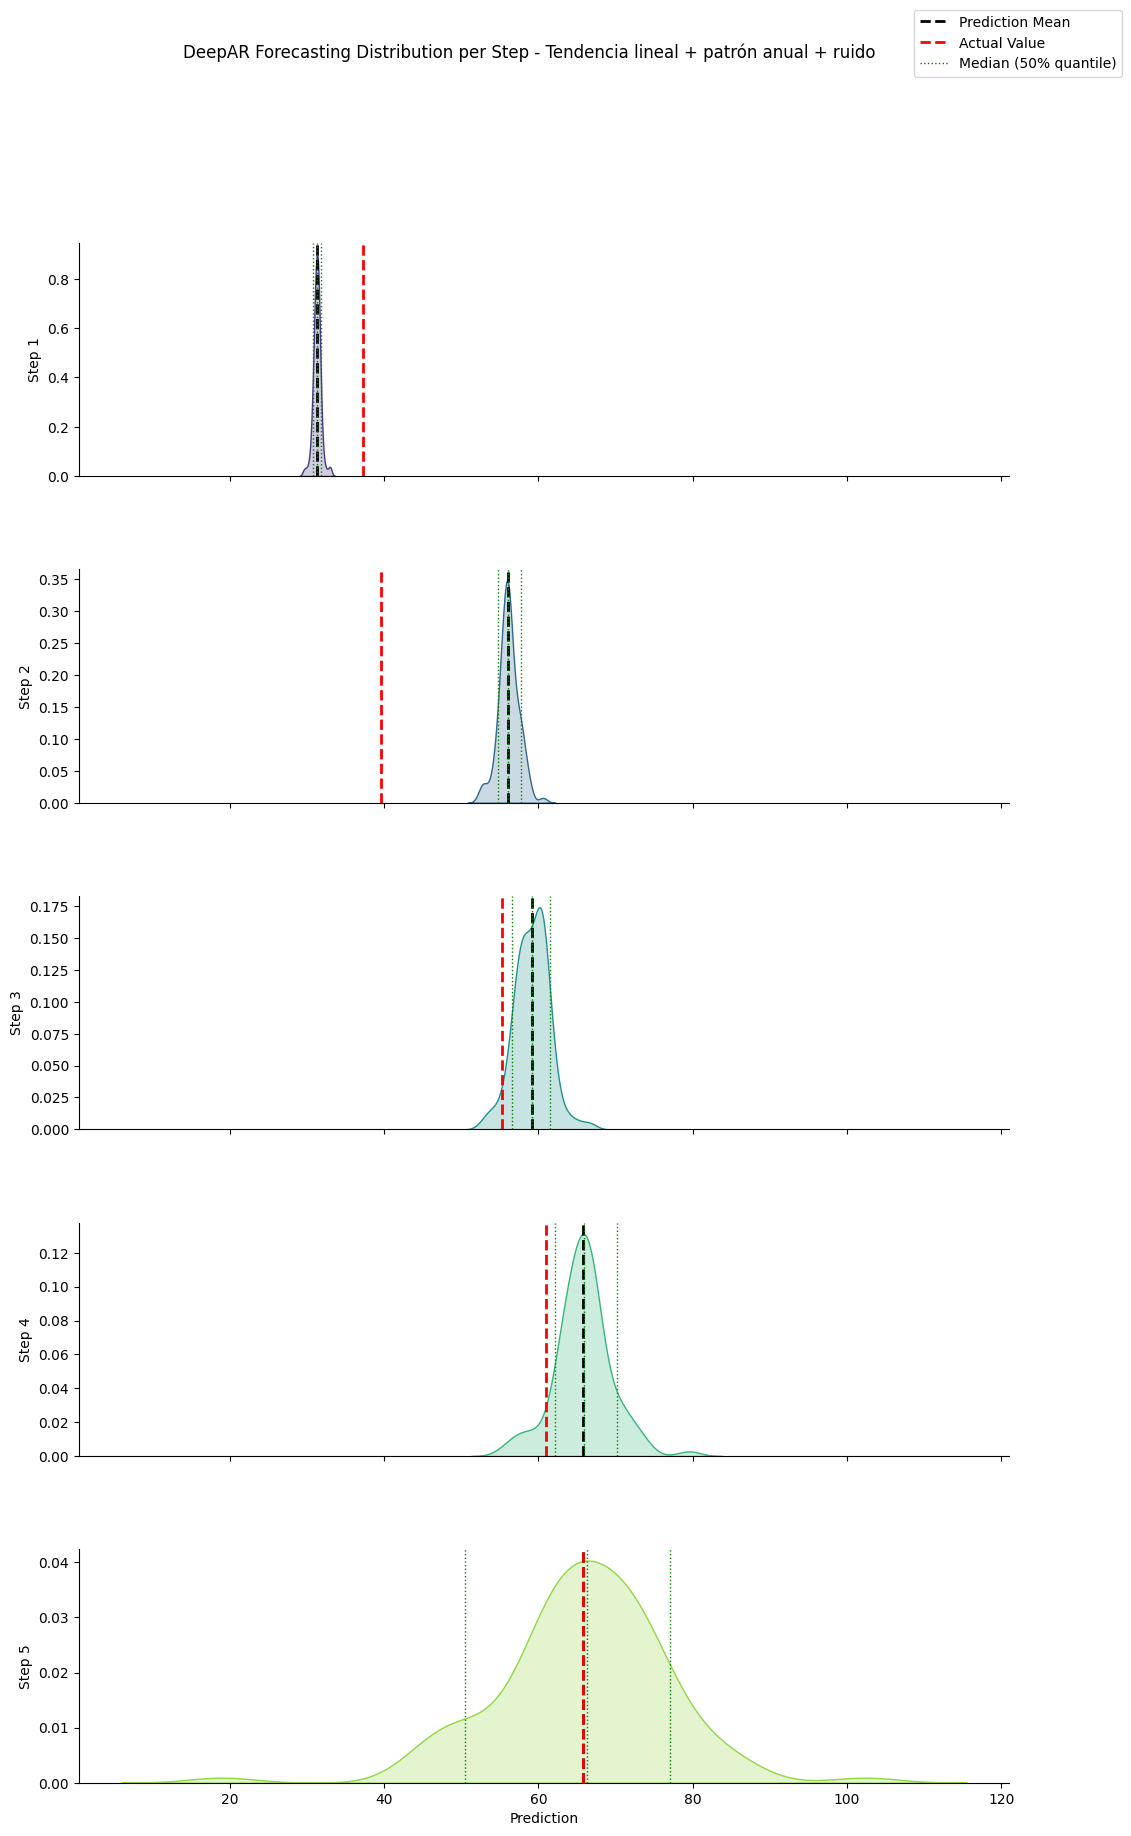

Resumen de predicciones para Tendencia lineal + patrón anual + ruido:

Paso 1:
  Valor real: 37.22
  Predicción media: 31.27
  Predicción mediana: 31.29
  Intervalo de predicción (80%): [30.73, 31.78]

Paso 2:
  Valor real: 39.64
  Predicción media: 56.10
  Predicción mediana: 56.05
  Intervalo de predicción (80%): [54.74, 57.77]

Paso 3:
  Valor real: 55.32
  Predicción media: 59.14
  Predicción mediana: 59.24
  Intervalo de predicción (80%): [56.53, 61.51]

Paso 4:
  Valor real: 60.95
  Predicción media: 65.76
  Predicción mediana: 65.88
  Intervalo de predicción (80%): [62.21, 70.22]

Paso 5:
  Valor real: 65.82
  Predicción media: 65.72
  Predicción mediana: 66.31
  Intervalo de predicción (80%): [50.53, 77.06]


In [2]:


# Generate the time series
start_date = pd.Timestamp("2019-01-01")
num_samples = 100

time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

time_series = [time_series1]
titles = ['Tendencia lineal + patrón anual + ruido']

# Create and use the forecaster
forecaster = DeepARForecasting(start_date="2019-01-01", freq="ME", prediction_length=5, epochs=20)

for series, title in zip(time_series, titles):
    forecaster.add_time_series(series, title)

forecaster.run_forecasting_process(series_index=0, n_trials=5)

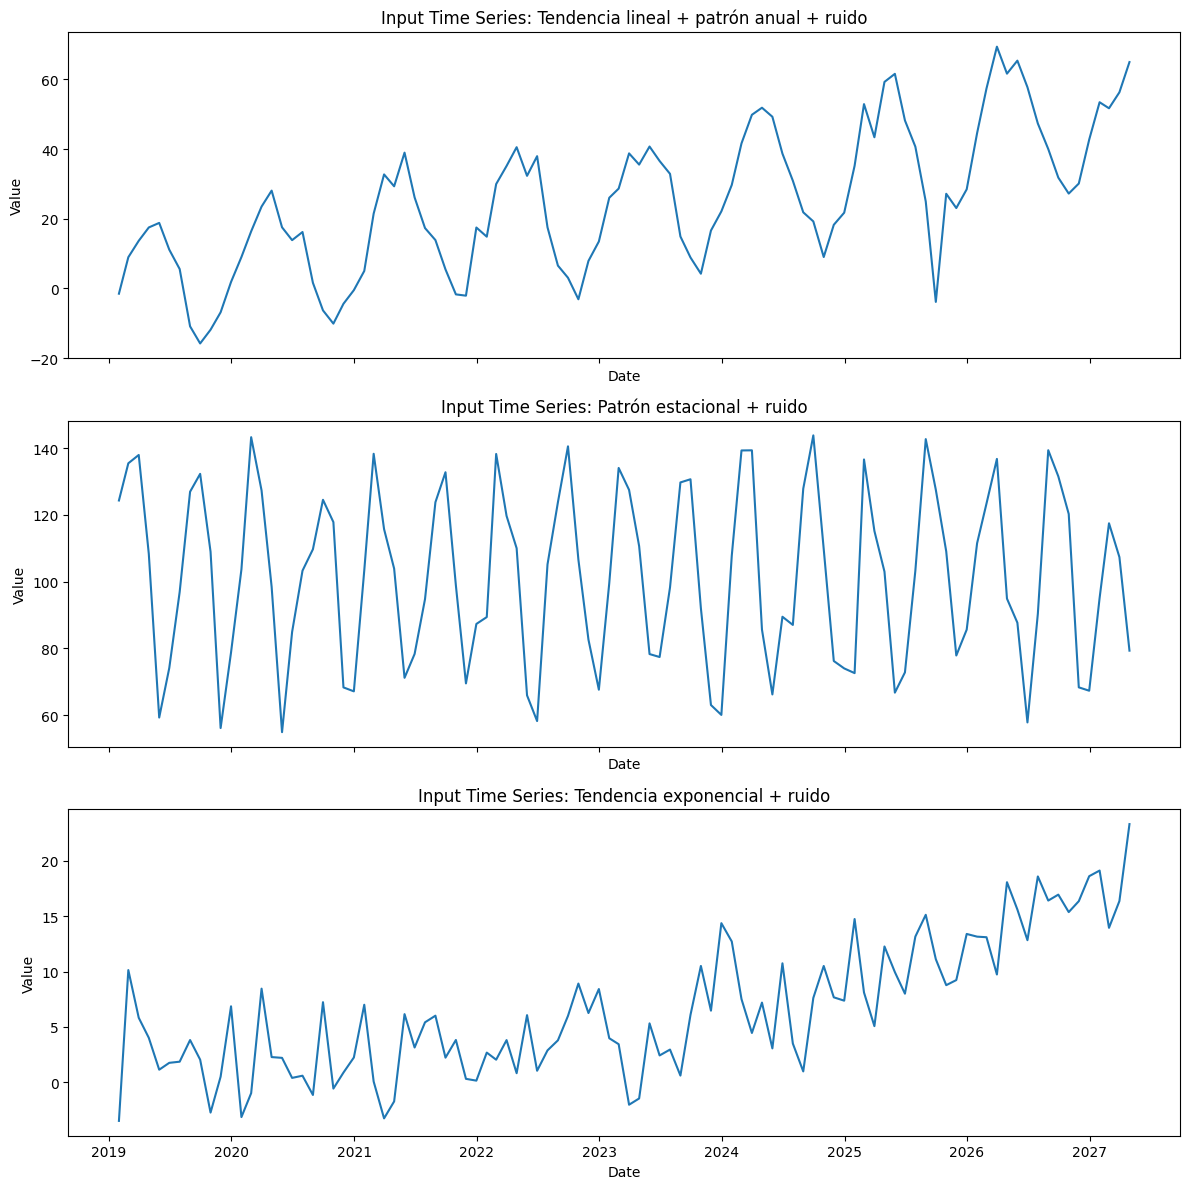

[I 2024-09-23 21:07:33,165] A new study created in memory with name: no-name-0459d01a-598f-4aef-a4d4-0347e46dc73d


Starting hyperparameter tuning...


Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 24.80it/s]
[I 2024-09-23 21:08:11,485] Trial 0 finished with value: 0.06489216544508042 and parameters: {'num_layers': 1, 'neurons_per_layer': 16}. Best is trial 0 with value: 0.06489216544508042.
Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.33it/s]
[I 2024-09-23 21:08:50,850] Trial 1 finished with value: 0.07375482351943982 and parameters: {'num_layers': 1, 'neurons_per_layer': 32}. Best is trial 0 with value: 0.06489216544508042.
Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.97it/s]
[I 2024-09-23 21:09:33,522] Trial 2 finished with value: 0.06097622965036656 and parameters: {'num_layers': 2, 'neurons_per_layer': 32}. Best is trial 2 with value: 0.06097622965036656.
Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 22.51it/s]
[I 2024-09-23 21:10:10,071] Trial 3 finished with value: 0.06744956516552435 and parameters: {'num_layers': 1, 'neurons_per_layer': 8}. Best is trial 2 with value: 0.060976229650

Number of finished trials: 5

Best trial:
  Value: 0.06097622965036656
  Params: 
    num_layers: 2
    neurons_per_layer: 32
Time taken: 200.90 seconds

Training model with best parameters...


100%|██████████| 100/100 [00:03<00:00, 25.11it/s, epoch=50/50, avg_epoch_loss=2.07]


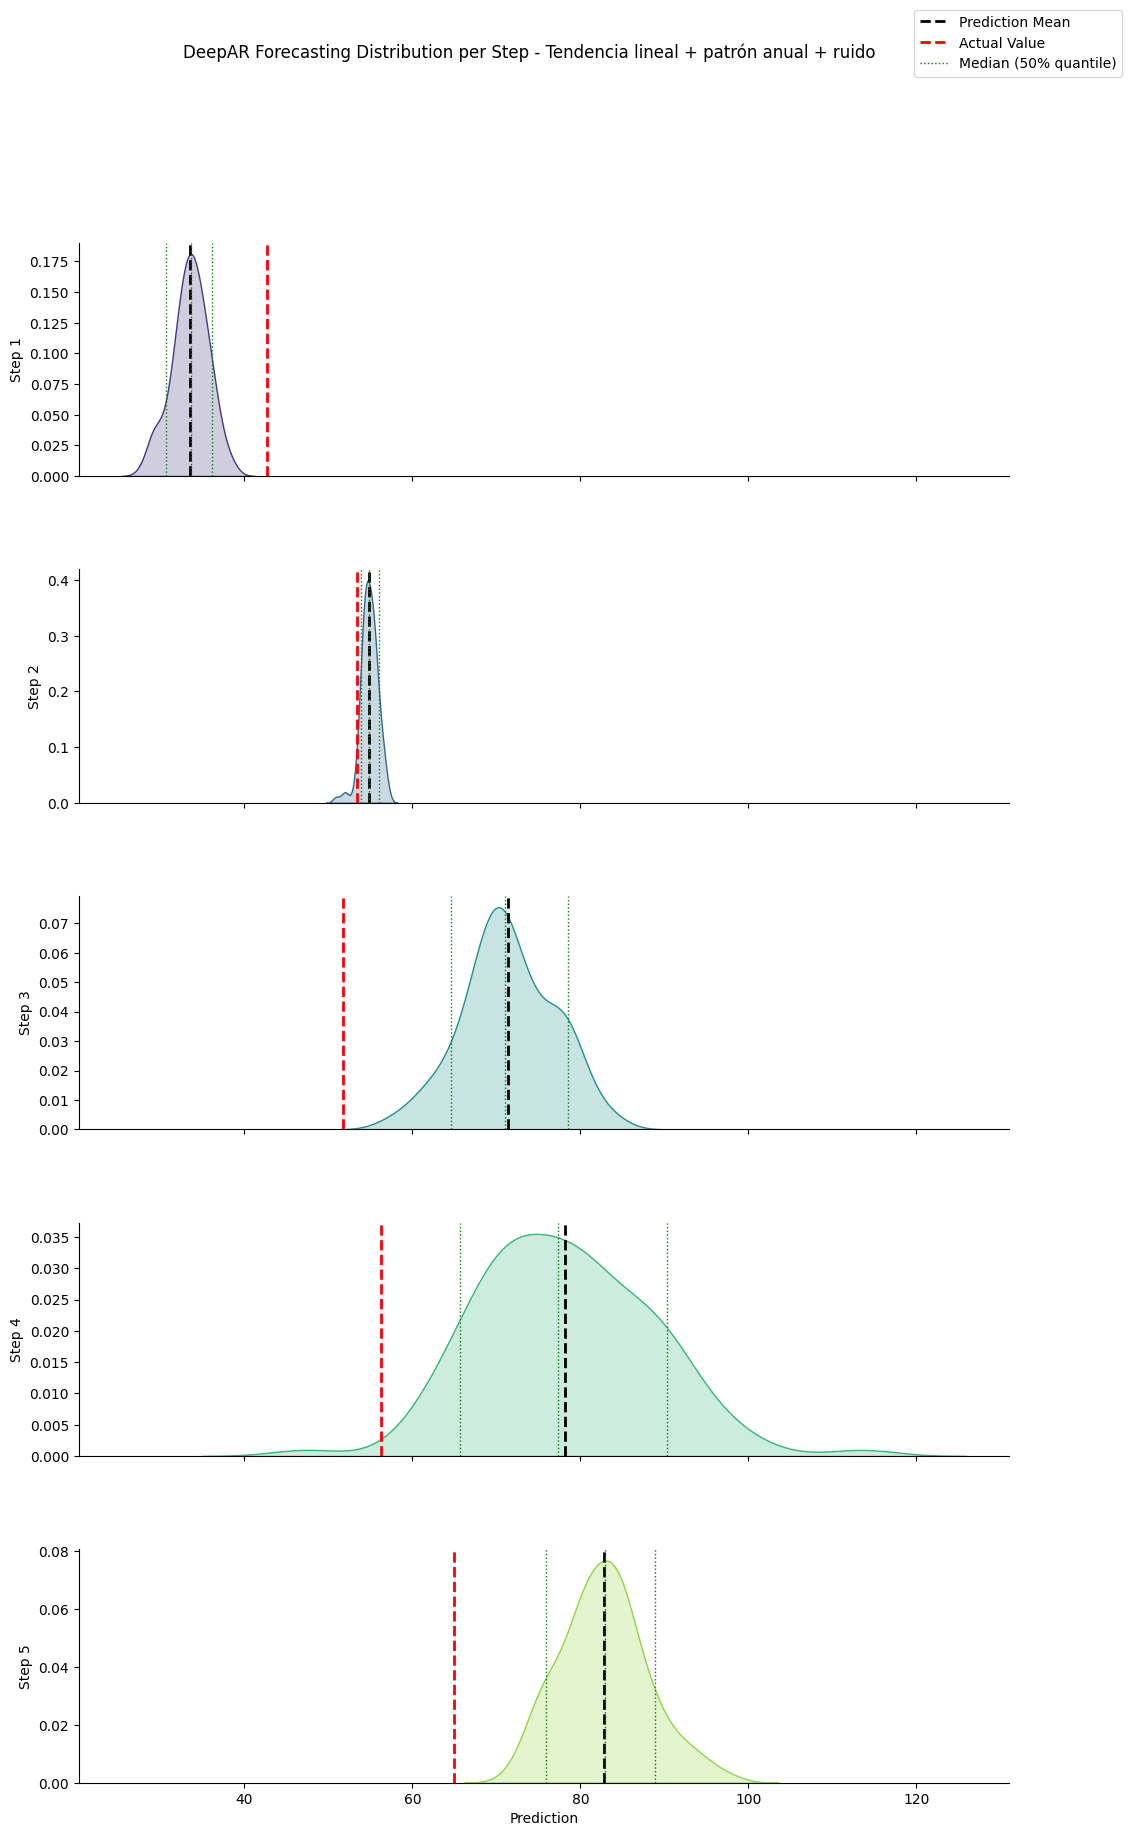

Resumen de predicciones para Tendencia lineal + patrón anual + ruido:

Paso 1:
  Valor real: 42.70
  Predicción media: 33.53
  Predicción mediana: 33.67
  Intervalo de predicción (80%): [30.71, 36.16]

Paso 2:
  Valor real: 53.42
  Predicción media: 54.84
  Predicción mediana: 54.85
  Intervalo de predicción (80%): [53.91, 56.01]

Paso 3:
  Valor real: 51.68
  Predicción media: 71.39
  Predicción mediana: 71.04
  Intervalo de predicción (80%): [64.66, 78.53]

Paso 4:
  Valor real: 56.27
  Predicción media: 78.16
  Predicción mediana: 77.63
  Intervalo de predicción (80%): [65.76, 90.32]

Paso 5:
  Valor real: 64.94
  Predicción media: 82.85
  Predicción mediana: 83.11
  Intervalo de predicción (80%): [75.94, 88.84]


In [3]:

start_date = pd.Timestamp("2019-01-01")
num_samples = 100

# Generate the time series
time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

time_series2 = np.sin(np.arange(num_samples) * 2 * np.pi / 6) * 30 + \
               np.random.normal(loc=100, scale=10, size=num_samples)

time_series3 = np.exp(np.arange(num_samples) * 0.03) + \
               np.random.normal(loc=0, scale=3, size=num_samples)

time_series = [time_series1, time_series2, time_series3]
titles = ['Tendencia lineal + patrón anual + ruido',
          'Patrón estacional + ruido',
          'Tendencia exponencial + ruido']

# Create and use the forecaster
forecaster = DeepARForecasting(start_date="2019-01-01", freq="ME", prediction_length=5, epochs=20)

for series, title in zip(time_series, titles):
    forecaster.add_time_series(series, title)
    
forecaster.run_forecasting_process(series_index=0)